# Pok&eacute;Map
Built using the Tutte Institute Data Science stack: https://github.com/tutteinstitute. <br>
Data taken from Pok&eacute;API: https://pokeapi.co/.
 
Author: Kaleb D. Ruscitti.

## Topic Modelling

Now that you've learned how to visualize data (see tutorial-recipes-bag-of-words.ipynb !), we're going to try sorting our data into topics.

In this case, our data points will be Pokemon, fetched gratefully from PokeAPI. A <i> topic </i> in this context means a group of pokemon which are similar in some way. Precisely in what way? Well that will depend on how we model Pokemon as mathematical objects, which we will discuss below.

In modern topic modelling, a baseline to define a topic is a <i> cluster </i>, which is a region of relative density in the space of data. Typically, one looks for these regions in the 'low-space', meaning the space of data after it has been dimensionally reduced. Thus, our starting point is to use what we learned in the previous tutorial to find a low-dimensional representation of our data.

Once we've run a clustering algorithm, we will have the clusters helpfully labeled with... an integer... In order to extract meaningful information out of the clustering result, we will want to find a better way to <i> represent </i> our clusters. This requires us to look inside the cluster and interpret what we see. 

All said, when we're doing topic modelling we can add two more steps to the pipeline from before: vectorize, information weight, UMAP, cluster, represent.


## Refresher: Vectorize, Information Weight, UMAP

In the previous tutorial, you learned that the basic recipe for visualizing data is to turn your data points into vectors, apply the information weight transform, and then use a dimensional reduction algorithm like UMAP.

One again we're going to go through these exact steps, but this time we'll talk a little bit more about the choices involved in the vectorizing and dimension reduction steps. Each step has some modelling choices or parameters that need to be selected, and these decisions can affect the final output of the data. Hopefully, you can use your understanding of the problem to find some set of parameters which are more justified that other. Moreover, we can try different sets of choices and try to identify patterns in the data which are invariant under these choices.


## Imports
If any packages are installed you will need to restart the kernel.

In [1]:
try:
    from umap import UMAP
    from hdbscan import HDBSCAN
    from vectorizers import NgramVectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    from vectorizers.transformers import InformationWeightTransformer
    from sklearn.decomposition import PCA
    import datamapplot
except:
    %pip install umap-learn vectorizers hdbscan datamapplot
    print("Please restart the kernel!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/kdruscit/.conda/envs/sklearn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kdruscit/.conda/envs/sklearn/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Loading Data
Load the file `pokedex.feather` included in this repository. The file `fetch.py` can be modified to obtain other data from PokeAPI if you wish.

In [2]:
pokedex = pd.read_feather('data/pokedex.feather')
pokedex.head()

,name,type,abilities,moves,stats
0,bulbasaur,"[grass, poison]","[overgrow, chlorophyll]","[razor-wind, swords-dance, cut, bind, vine-whi...","[45, 49, 49, 65, 65, 45]"
1,ivysaur,"[grass, poison]","[overgrow, chlorophyll]","[swords-dance, cut, bind, vine-whip, headbutt,...","[60, 62, 63, 80, 80, 60]"
2,venusaur,"[grass, poison]","[overgrow, chlorophyll]","[swords-dance, cut, bind, vine-whip, headbutt,...","[80, 82, 83, 100, 100, 80]"
3,charmander,[fire],"[blaze, solar-power]","[mega-punch, fire-punch, thunder-punch, scratc...","[39, 52, 43, 60, 50, 65]"
4,charmeleon,[fire],"[blaze, solar-power]","[mega-punch, fire-punch, thunder-punch, scratc...","[58, 64, 58, 80, 65, 80]"


## Vectorizing
In order to do any data science with pokemon, we need a way to turn a pokemon into a vector. There are many attributes associated to each Pokemon. They have heights and weights, colours, types, moves, stats, pokedex entries and so on. The first modelling choice that the data scientist must make is

` Which attributes of my data are relevant to the question I am studying? `

In this case, I want to group Pokemon by their use in Pokemon battles. Many attributes of the Pokemon, such as their height, egg group, pokedex entries, have no affect on the gameplay of a Pokemon battle. Some of the key attributes that do affect battles are the Pokemon's moves, type, abilities and stats, and so those are the attributes that I have included in my dataset.

One could instead use attributes like weight, height, colour and egg group to include information about the Pokemon's appearance. In this case, our groups of Pokemon would be ones which look similar. When communicating the results of your data analysis to others, it is important to make sure that you specify the modelling choices that you made, and explain how they affect your results!

Once I have my dataframe of attributes that I wish to include, we must turn these into vectors. Once again, we will use the <i> bag of words</i> approach. 

The CountVectorizer object from scikit-learn will take in a list of words and turn it into a vector that counts the number of appearances of each word. Therefore we just need to turn each pokemon into a list of words. For moves, abilities and type this is straightforward:

In [3]:
## Appending names, moves & abilities together.
tokens = []
for i, name in enumerate(pokedex['name'].to_list()):
    abil_tokens = ''.join(x.replace("-","_")+' ' for x in list(pokedex['abilities'].iloc[i]))
    move_tokens = ''.join(x.replace("-","_")+' ' for x in list(pokedex['moves'].iloc[i]))
    tokens.append(abil_tokens + ' ' + move_tokens)


pokedex['tokens']=tokens
print("Pikachu's tokens:")
print(pokedex['tokens'].iloc[24])

Pikachu's tokens:
static lightning_rod  mega_punch pay_day thunder_punch slam double_kick mega_kick headbutt body_slam take_down double_edge tail_whip growl surf submission counter seismic_toss strength thunder_shock thunderbolt thunder_wave thunder dig toxic agility quick_attack rage mimic double_team defense_curl light_screen reflect bide swift skull_bash flash rest substitute thief snore curse reversal protect sweet_kiss mud_slap zap_cannon detect endure charm rollout swagger spark attract sleep_talk return frustration dynamic_punch encore iron_tail hidden_power rain_dance rock_smash uproar facade focus_punch charge helping_hand brick_break knock_off endeavor secret_power fake_tears signal_beam covet volt_tackle calm_mind shock_wave natural_gift feint fling magnet_rise nasty_plot discharge captivate grass_knot charge_beam electro_ball round echoed_voice volt_switch electroweb wild_charge disarming_voice draining_kiss play_rough play_nice confide eerie_impulse electric_terrain nuzzle

However a pokemon's stats are not categorical data like moves and abilities. Therefore we need to make a choice on how to include a pokemon's stats in the data. I've decided to turn the stats into additional words by taking the top two stats of any given pokemon.

We can throw these extra words into the CountVectorizer, however we can do slightly better. If we count digrams (pairs of words) instead of single word count, we can keep track of the order of the top two stats, and therefore get a more refined embedding of the pokemon as vectors. This means that DEF ATK and ATK DEF will be considered different objects. However we also want to remember that DEF ATK and ATK DEF are closer together then DEF ATK and SPA SPE; so we will also count the individual words. To do this we pass the parameter `ngram_range=(1,2)` to the second CountVectorizer.

In [4]:
## Turning stats into digrams
stat_arr = pokedex['stats'].to_numpy()
stat_names = ['HP','ATK','DEF','SPA','SPD','SPE']
top_stats = []
second_stats = []
for row in stat_arr:
    if np.amax(row) == np.amin(row):
        top_stats.append('ALL')
        second_stats.append('')
    else:
        srt=np.argsort(row)
        top_stats.append(stat_names[srt[-1]])
        second_stats.append(stat_names[srt[-2]])
    
pokedex['top_stat'] = top_stats
pokedex['second_stat'] = second_stats

In [5]:
vectorizer = CountVectorizer()
token_vectors = vectorizer.fit_transform(pokedex['tokens'].to_list())
# vectors is a sparse matrix, but we don't have that much data so let's densify it.
token_vectors = token_vectors.toarray()
print(np.shape(token_vectors))

(1025, 1080)


In [6]:
stat_vectorizer = CountVectorizer(ngram_range=(1,2))
tmp = (pokedex['top_stat'] +" "+ pokedex['second_stat']).to_list()
stat_vectors = stat_vectorizer.fit_transform(tmp)
stat_vectors = stat_vectors.toarray()
N_digrams = np.shape(stat_vectors)[1]

Now that we've vectorized the word data and the stats, we can combine them:

In [7]:
vectors = np.concatenate((token_vectors, stat_vectors), axis=1)

## Information Weighting
Now a pokemon is a binary vector which encodes what moves, abilities, types and stats it has. However, not all moves and abilities are equally informative about what distinguishes pokemon. Some moves or abilities are very unique and define the pokemon that have them, such as Spore or Huge Power. Others are commonplace like Tackle. 

When measuring the distance between two pokemon we want to place a higher weight on these more distinctive moves. The Information Weight Transform takes a list of vectors and does exactly this; it weights each feature (move, ability, etc) by the amount of <i> information </i> that it tells us about the pokemon, relative to all other pokemon. The working principle is similar to TF-IDF, if you've heard of it.

In [8]:
## Information Weighting:
IWT = InformationWeightTransformer()
vectors_IWT = IWT.fit_transform(vectors)

/home/kdruscit/.conda/envs/sklearn/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


## Dimension Reduction: UMAP
Now in order to categorize pokemon and plot them on a map, we need to do a dimension reduction. The vectors we've built have too many dimensions to visualize:

In [9]:
print("The vectors have",np.shape(vectors)[1],"dimensions!")

The vectors have 1117 dimensions!


Dimension reduction tools allow you to map a set of vectors in high dimensions to a lower dimensional space, while approximately preserving the distance between the vectors. Here again we use UMAP. UMAP has a few parameters we can select, see <a href=https://umap-learn.readthedocs.io/en/latest/parameters.html> the UMAP docs.</a> I encourage you to try re-running UMAP with different parameters to see how it affects the output.

Inputting our information-weighted vectors, we will get out a pair of co-ordinates (x,y) for each pokemon, which we can put in a scatter plot.

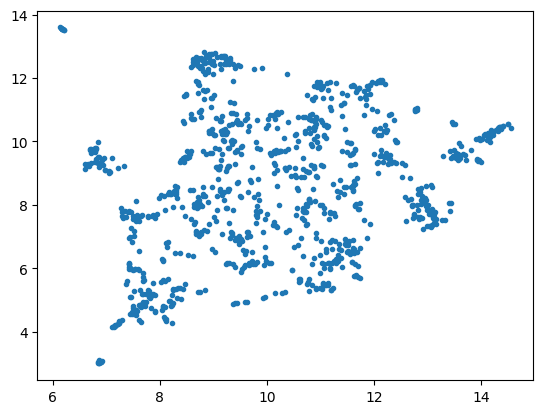

In [10]:
# This may take a few seconds.
use_included_data = True

if use_included_data:
    ## This loads the data exactly as used on the website.
    data = np.load("data/pokedex_umap.npy")
else:
    ## This generates a new map, which will break the labels (see below).
    UMAP2d = UMAP(n_components=2, metric='cosine')
    data = UMAP2d.fit_transform(vectors_IWT)
plt.scatter(
    data[:,0],
     data[:,1],
     marker='.',
) 
plt.show()

There are a couple things to keep in mind: <br>
First, the absolute x and y scales of the UMAP data do not have any meaning. Only the relative distance between points means anything. <br>
Second, while UMAP preserves local distances fairly well, the long-range distances must be distorted. Compromises must be made to reduce 1000+ dimensions down to 2!

## Clustering
Now that our Pokemon are represented as points in the plane, we can run a clustering algorithm to find dense groupings of pokemon. At the Tutte Institute we are partial to our inhouse algorithm, HDBSCAN.

HDBSCAN will assign an integer cluster label to each point, indicating which cluster it belongs to. Points which get -1 are considered to be "noise", meaning they are outliers or they fit between multiple clusters. 

The critical parameter of HDBSCAN is the minimum cluster size, which you should set depending on how fine a resolution of topic you want to find. In my case, I want pretty fine clusters, but I don't want a single evolution family of Pokemon to be there own cluster (for example, Bulbasaur, Ivysaur, Venusaur). The largest Pokemon families have only 3 members, so I will set the minimum cluster size to 4.

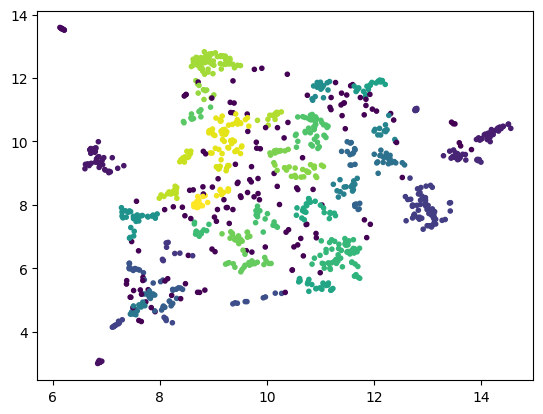

146 noise points: 14.243902439024389 %


In [11]:
clusterer = HDBSCAN(min_cluster_size=4)
clusterer.fit(data)
cluster_labels = clusterer.labels_
plt.scatter(
    data[:,0],
    data[:,1],
    marker='.',
    c=cluster_labels
)
plt.show()
n_noise = np.size((cluster_labels==-1).nonzero())
print(n_noise,"noise points:", (n_noise/1025)*100, "%")

## Labelling Clusters
Unfortunately, HDBSCAN doesn't know anything about pokemon. Or about anything really. So it can only give the clusters a numeric label. To get more interesting labels, we need to take a look at the data points that lie within each cluster.

To do this, we can look at the pokemon within each cluster, and we can also get some of the highest information-weighted keywords that are associated to each cluster.

In [12]:
## Get keywords & members of each cluster.
N_clusters = np.size(np.unique(cluster_labels))
N_features = np.shape(vectors)[1]
cluster_vectors = np.zeros((N_clusters, N_features))
keywords = np.zeros((1025,3), dtype=object)
for i, c_name in enumerate(np.unique(cluster_labels)):
    c_idx = (cluster_labels == c_name).nonzero()
    mons_in_cluster = pokedex['name'].iloc[c_idx].values
    cluster_sum_vector = np.sum(vectors_IWT[c_idx],axis=0)
    cluster_vectors[i] = cluster_sum_vector
    
    
weighted_cvecs = IWT.fit_transform(cluster_vectors)
for i, c_name in enumerate(np.unique(cluster_labels)):
    c_idx = (cluster_labels == c_name).nonzero()
    srt = np.argsort(weighted_cvecs[i])
    cl_keywords = np.array(['','',''],dtype=object)
    for k in range(1,4):
        if srt[-k] < N_features - N_digrams:
            cl_keywords[k-1] = vectorizer.get_feature_names_out()[srt[-k]]
        else:
            cl_keywords[k-1] = stat_vectorizer.get_feature_names_out()[srt[-k]-(N_features - N_digrams)]
    keywords[c_idx] = cl_keywords


In [13]:
def clusterInfo(c_val):
    cl_idx = (cluster_labels==c_val).nonzero()
    print("CLUSTER:",c_val)
    print("Keywords for this cluster are:",keywords[cl_idx[0][0]])
    print("Pokemon in this cluster are:", pokedex['name'].to_numpy()[cl_idx])
    print("-------------------------")
    
clusterInfo(33)

CLUSTER: 33
Keywords for this cluster are: ['synchronize' 'forewarn' 'mystical_power']
Pokemon in this cluster are: ['abra' 'kadabra' 'alakazam' 'drowzee' 'hypno' 'starmie' 'mr-mime' 'jynx'
 'mewtwo' 'natu' 'xatu' 'espeon' 'umbreon' 'unown' 'girafarig' 'stantler'
 'smoochum' 'ralts' 'kirlia' 'gardevoir' 'lunatone' 'solrock' 'baltoy'
 'claydol' 'chimecho' 'latias' 'latios' 'deoxys-normal' 'chingling'
 'bronzor' 'bronzong' 'mime-jr' 'uxie' 'mesprit' 'azelf' 'cresselia'
 'munna' 'musharna' 'solosis' 'duosion' 'reuniclus' 'elgyem' 'beheeyem'
 'cosmoem' 'lunala' 'orbeetle' 'indeedee-male' 'eternatus' 'wyrdeer'
 'rabsca' 'farigiraf']
-------------------------


To turn this list of pokemon and keywords into a short name for the cluster, one could consider writing a prompt and asking an LLM to provide a distinctive name. This turns out to be a subtle problem; see https://github.com/tutteinstitute/topicnaming .
Since we don't have that many clusters and I'm writing this tutorial with my dinky laptop over VIA Rail Wi-Fi, I will look at the keywords and pokemon and give them a name myself.

If you have a better suggestion for any of these names, I'd love to hear it!

In [14]:
'''
WARNING: If you re-ran the code then you will have different clusters (due to UMAP randomness) and the naming will not match. 
'''
cluster_names = {
    0:"Future Paradox",
    1:"Past Paradox",
    2:"Ice",
    3:"Fire",
    4:"Fire Starters",
    5:"Magic",
    6:"DEF&HP",
    7:"Applin",
    8:"Birds",
    9:"Mushrooms",
    10:"Flower",
    11:"Food Fairies",
    12:"Phys. Grass Starters",
    13:"Horn Leech",
    14:"Fruit",
    15:"Fangs",
    16:"Rivalry",
    17:"Spec. Grass Starters",
    18:"Dragon",
    19:"Utility Grass",
    20:"Leaf/Vine",
    21:"Jaws",
    22:"Shed Skin",
    23:"Weapons",
    24:"Arachnids",
    25:"Water Starters",
    26:"Greninja",
    27:"Lepidoptera 1",
    28:"Lepidoptera 2",
    29:"Fairy",
    30:"???",
    31:"Rodents",
    32:"Shadow Tag",
    33:"Psychic",
    34:"Cephalopods",
    35:"Hungry",
    36:"Fighting",
    37:"Rock",
    38:"Ghost",
    39:"Poison",
    40:"Pinchers",
    41:"Dogs",
    42:"Mechanical",
    43:"Electric",
    44:"Sword",
    45:"Fish",
    46:"Shells",
    47:"Poison Barbs",
    48:"Ground/Rock",
    49:"Bulky ?",
    50:"Water",
    -1:"Unclassified"
}

try:
    string_labels = [cluster_names[x] for x in cluster_labels]
except(KeyError):
    print("Clusters do not match labels!")
    string_labels = [''.join(x+"\n ") for x in keywords]

## Creating the Datamap
Now all that is left to do is a make a nice looking plot! To do this we will use datamapplot. First we can generate some nice looking labels for each Pokemon when you hover over it's marker.

In [15]:
hover_data = pd.DataFrame()
names_nice = [x.capitalize() for x in pokedex['name'].to_list()]
hover_data["Name"]=names_nice
type_nice = []
for row in pokedex['type'].to_list():
    tmp = ''
    for word in row:
        tmp += word.capitalize()+" "
    type_nice.append(tmp)
hover_data["Type"]=type_nice
hover_data["TopStats"] = pokedex["top_stat"]+" "+pokedex["second_stat"]

In [16]:
distinctive_words = []
for i, mon in enumerate(pokedex['name']):
    vec = vectors_IWT[i]
    srt = np.argsort(vec)
    kw =  ''
    for k in range(1,3):
        if srt[-k] < N_features - N_digrams:
            kw += vectorizer.get_feature_names_out()[srt[-k]].capitalize()
            kw += " "
        else:
            kw += stat_vectorizer.get_feature_names_out()[srt[-k]-(N_features - N_digrams)].capitalize()
            kw += " "
    distinctive_words.append(kw)
hover_data["KW"] = distinctive_words

We can also resize each marker by the pokemon's BST.

In [17]:
size_arr = np.zeros(1025)
for i, statline in enumerate(pokedex['stats']):
    size_arr[i] = (np.sum(statline)/400)


 Lastly, we pass all the arguments to datamapplot!

In [18]:
fig = datamapplot.create_interactive_plot(
    data,
    string_labels,
    title="Pok&eacute;Map",
    hover_text=hover_data['Name'].to_list(),
    extra_point_data = hover_data,
    hover_text_html_template = """
        <div>
            <h3>{hover_text}</h3>
            <p>Type: {Type}</p>
            <p>Top Stats: {TopStats}</p>
            <p>Notable: {KW}</p>
        </div>
        """,
    enable_search=True,
    marker_size_array=size_arr,
    #font_family="Arial",
)
fig

<InteractiveFigure width=100% height=800>

## Conclusion
In this tutorial, we introduced topic modelling. In particular I've tried to convey the type of considerations that go into into making sensible models of your data. Try running the pipeline again with different choices - you'll see that some groups of Pokemon almost always appear, such as the Paradox pokemon, but other groups are much more ephermeral. 

My interpretation is that any conclusion one obtains with a set of choices is a piece of evidence for the truth of the underlying statement. If many different sets of choices lead to the same conclusion, that means there is a lot of evidence that it is true! If a conclusion only occurs under a very specific set of choices, then those choices much be very strongly justified, otherwise the conclusion is probably spurrious.